# Example of using litstudy

This notebook shows an example of how to use `litstudy` from inside a Jupyter notebook. It shows how to load a dataset, plot statistics, topic modeling, network analysis, and some more advanced features. 

This notebook focuses on the topic of programming model for GPUs. GPUs (Graphic Processing Units) are specialized processors that are used in many data centers and supercomputers for data processing and machine learning. However, programming these devices remaining difficult, which is why there is a plethora of research on developing programming models for them.

## Imports

In [1]:
# Import other libraries 
import os
import sys
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10, 6)

import seaborn as sbs
sbs.set('paper')

# Import litstudy
path = os.path.abspath(os.path.join('..'))
if path not in sys.path:
    sys.path.append(path)

import litstudy

## Collecting the dataset

For this, example, we have searched both IEEE Xplore and Springer Link for the query `"GPU" and "programming model"`. IEEE Xplore gives 5 CSV files (1 per page) and Springer Link gives a single CSV file. We load all files and merge the resulting document sets.

In [2]:
# Load the CSV files
docs1 = litstudy.load_ieee_csv('data/ieee_1.csv')
docs2 = litstudy.load_ieee_csv('data/ieee_2.csv')
docs3 = litstudy.load_ieee_csv('data/ieee_3.csv')
docs4 = litstudy.load_ieee_csv('data/ieee_4.csv')
docs5 = litstudy.load_ieee_csv('data/ieee_5.csv')
docs_ieee = docs1 | docs2 | docs3 | docs4 | docs5
print(len(docs_ieee), 'papers loaded from IEEE')

docs_springer = litstudy.load_springer_csv('data/springer.csv')
print(len(docs_springer), 'papers loaded from Springer')

# Merge the two document sets
docs_csv = docs_ieee | docs_springer
print(len(docs_csv), 'papers loaded from CSV')

441 papers loaded from IEEE
1000 papers loaded from Springer
1441 papers loaded from CSV


We can also exclude some papers that we are not interested in. Here, we load a document set from a RIS file and subtract these documents from our original document set.

In [3]:
docs_exclude = litstudy.load_ris_file('data/exclude.ris')
docs_remaining = docs_csv - docs_exclude

print(len(docs_exclude), 'papers were excluded')
print(len(docs_remaining), 'paper remaining')

1 papers were excluded
1440 paper remaining


The metadata provided by the CSV files is not great. To solve this, we can lookup the papers on Scopus using `refine_scopus`. This function returns two sets: the set of Scopus documents that were found and the set of original documents not were not found on Scopus. We have two options here: (1) merge the two sets back into one set or (2) discard the documents that were not found. We chose the second option here for simplicity.

In [4]:
import logging
logging.getLogger().setLevel(logging.CRITICAL)

docs_scopus, docs_notfound = litstudy.refine_scopus(docs_remaining)

print(len(docs_scopus), 'papers found on Scopus')
print(len(docs_notfound), 'papers were not found and were discarded')

100%|██████████| 1440/1440 [00:03<00:00, 382.80it/s]

1387 papers found on Scopus
53 papers were not found and were discarded


Next, we plot the number of documents per publication source.

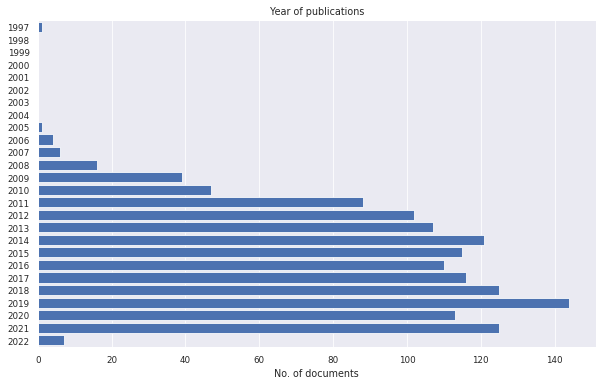

In [5]:
litstudy.plot_year_histogram(docs_scopus);

It appears there is one document from 1997. This is likely an error since GPUs were not used for general purpose computing before 2006. We can remove this document by filtering on year of publication.

In [6]:
docs = docs_scopus.filter_docs(lambda d: d.publication_year >= 2000)

Finally, we print how many papers are left

In [7]:
print(len(docs), 'papers remaining')

1386 papers remaining


## General statistics

litstudy supports plot many general statistics of the document set as histograms. We show some simple examples below. 

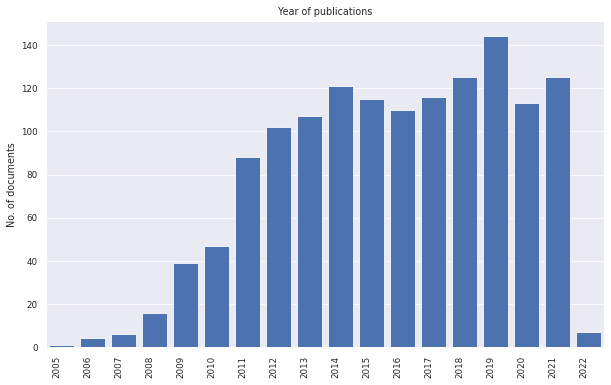

In [8]:
litstudy.plot_year_histogram(docs, vertical=True);

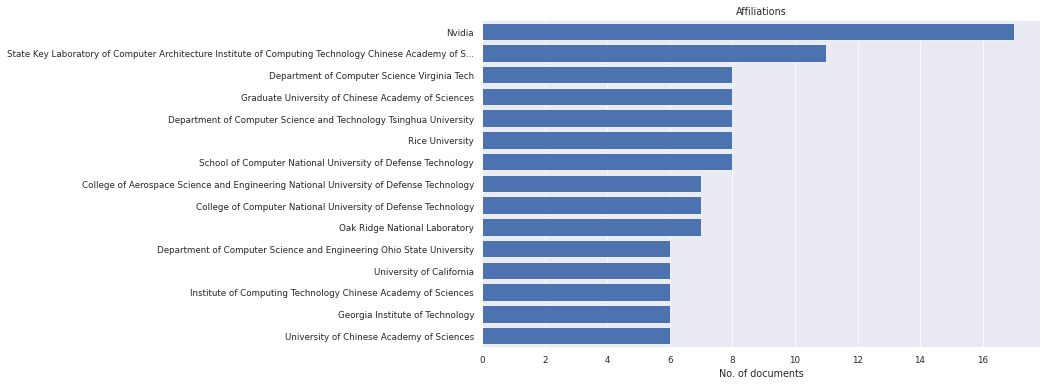

In [9]:
litstudy.plot_affiliation_histogram(docs, limit=15);

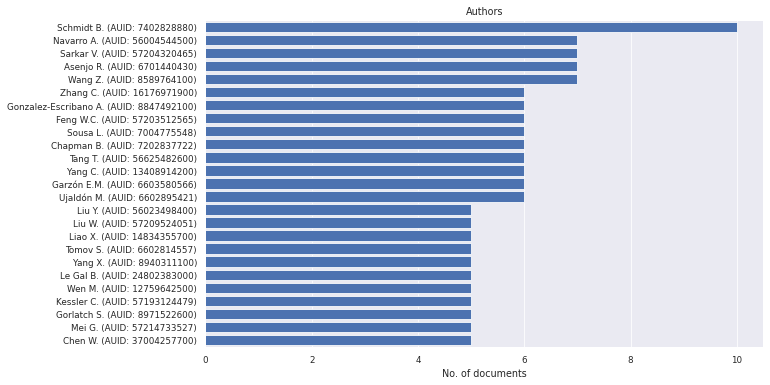

In [10]:
litstudy.plot_author_histogram(docs);

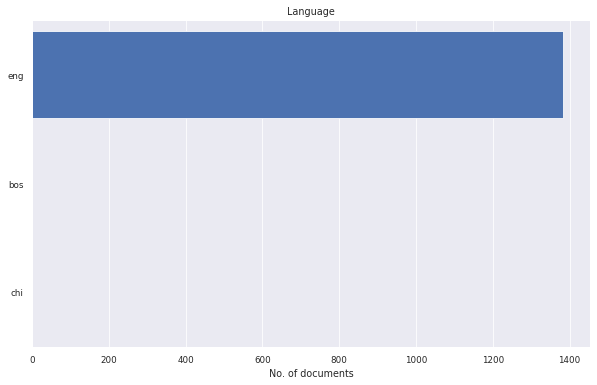

In [11]:
litstudy.plot_language_histogram(docs);

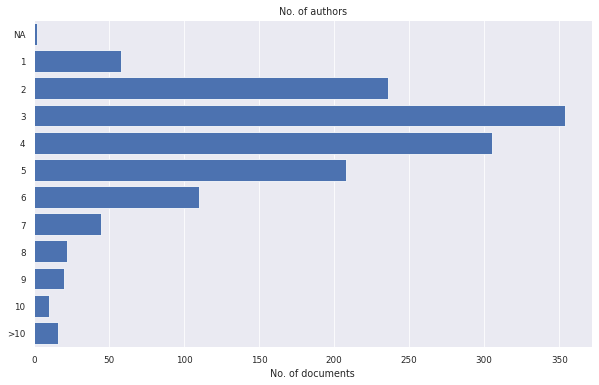

In [12]:
litstudy.plot_number_authors_histogram(docs);

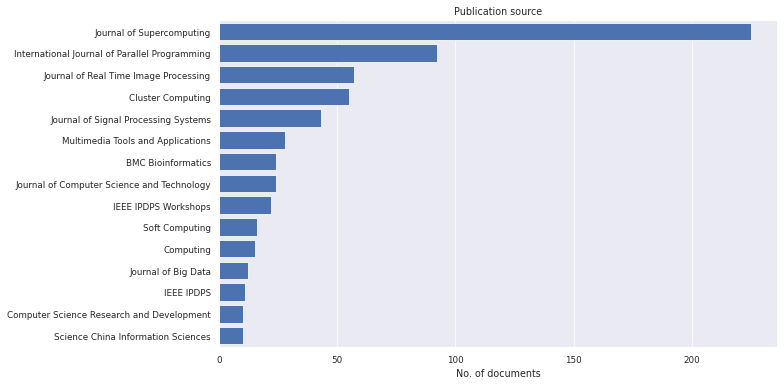

In [13]:
# This names are long, which is why a short abbreviation is provided.
mapping = {
    "IEEE International parallel and distributed processing symposium IPDPS": "IEEE IPDPS",
    "IEEE International parallel and distributed processing symposium workshops IPDPSW": "IEEE IPDPS Workshops",
}

litstudy.plot_source_histogram(docs, mapper=mapping, limit=15);

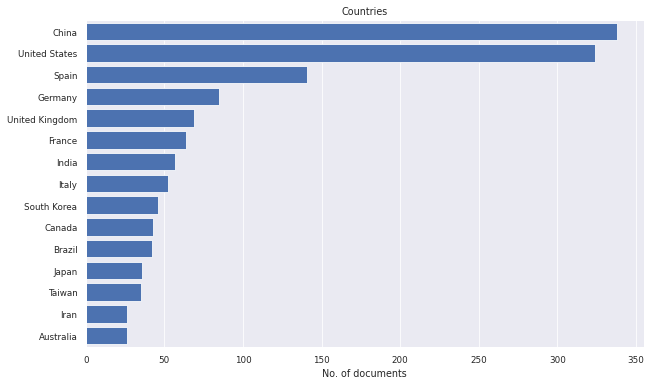

In [14]:
litstudy.plot_country_histogram(docs, limit=15);

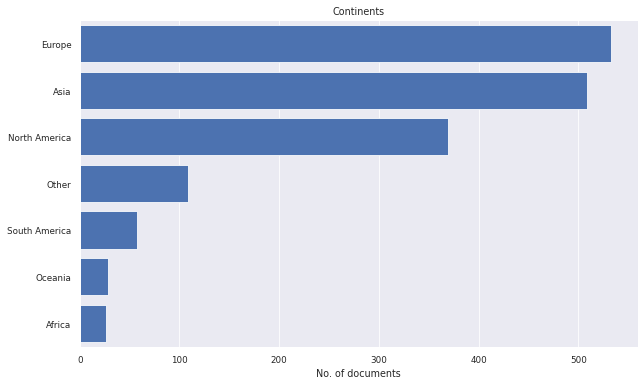

In [15]:
litstudy.plot_continent_histogram(docs);

## Network analysis

In [16]:
# litstudy.plot_cocitation_network(docs, max_edges=500)

## Topic modeling

litstudy supports automatic topic discovery based on the words used in documents abstracts. We show an example below. First, we need to build a corpus from the document set. Note that `build_corpus` supports many arguments to tweak the preprocessing stage of building the corpus. In this example, we pass `ngram_threshold=0.85` which will add commonly used n-grams (i.e., frequent consecutive words) to the corpus.

In [17]:
corpus = litstudy.build_corpus(docs, ngram_threshold=0.8)

We can compute a word distribution using `litstudy.compute_word_distribution` which how often each word occurs across all documents. In this example, we filter out the bigrams by only showing the words that contain an `_`. We see that words such as `artificial intelligence` and `trade offs` have been recognized as common bigrams.

In [18]:
litstudy.compute_word_distribution(corpus).filter(like='_', axis=0).sort_index()

,count
artificial_intelligence,13
author_exclusive,41
berlin_heidelberg,83
chinese_academy,6
coarse_grained,16
...,...
synthetic_aperture,7
trade_offs,10
unified_device,108
xeon_phi,21


Let's visualize the word distribution from this corpus.

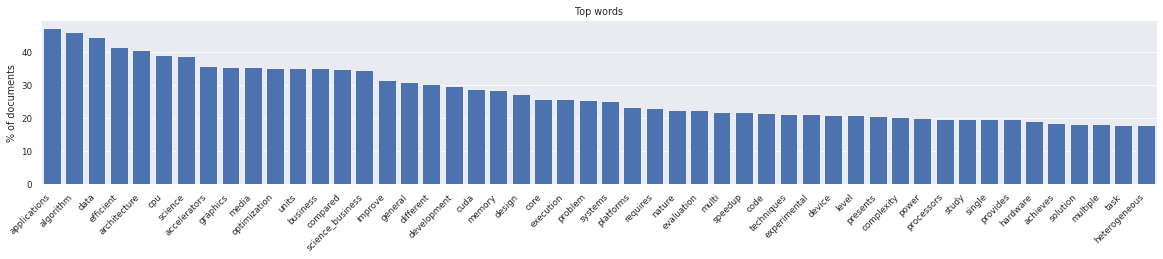

In [19]:
plt.figure(figsize=(20, 3))
litstudy.plot_word_distribution(corpus, limit=50, title="Top words", vertical=True, label_rotation=45);

The word distribution looks like what we would expect. Next, we run a NMF topic model for 15 topics. 

In [20]:
num_topics = 15
topic_model = litstudy.train_nmf_model(corpus, num_topics, max_iter=250)

To visualize the output of NMF, we can plot the each discovered topic as a word cloud. The size of each word indicates the importance of that word for that topic.

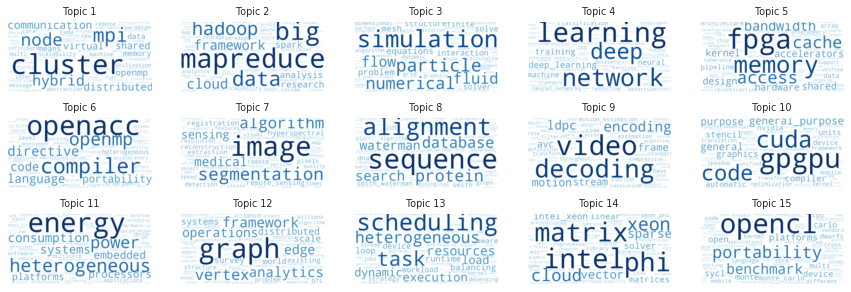

In [21]:
plt.figure(figsize=(15, 5))
litstudy.nlp.plot_topic_clouds(topic_model, ncols=5);

These 15 topics look promising. For example, there is one topic on graph processing, one on OpenACC, one on OpenCL, one on FPGAs, etc. 

We can visualize the results as a "landscape" plot. This is a visual appealing way to place documents on a map. The documents are placed such that similar documents are located closed to each other. However, this is a non-linear embedding so the distances between the documents are not linear.

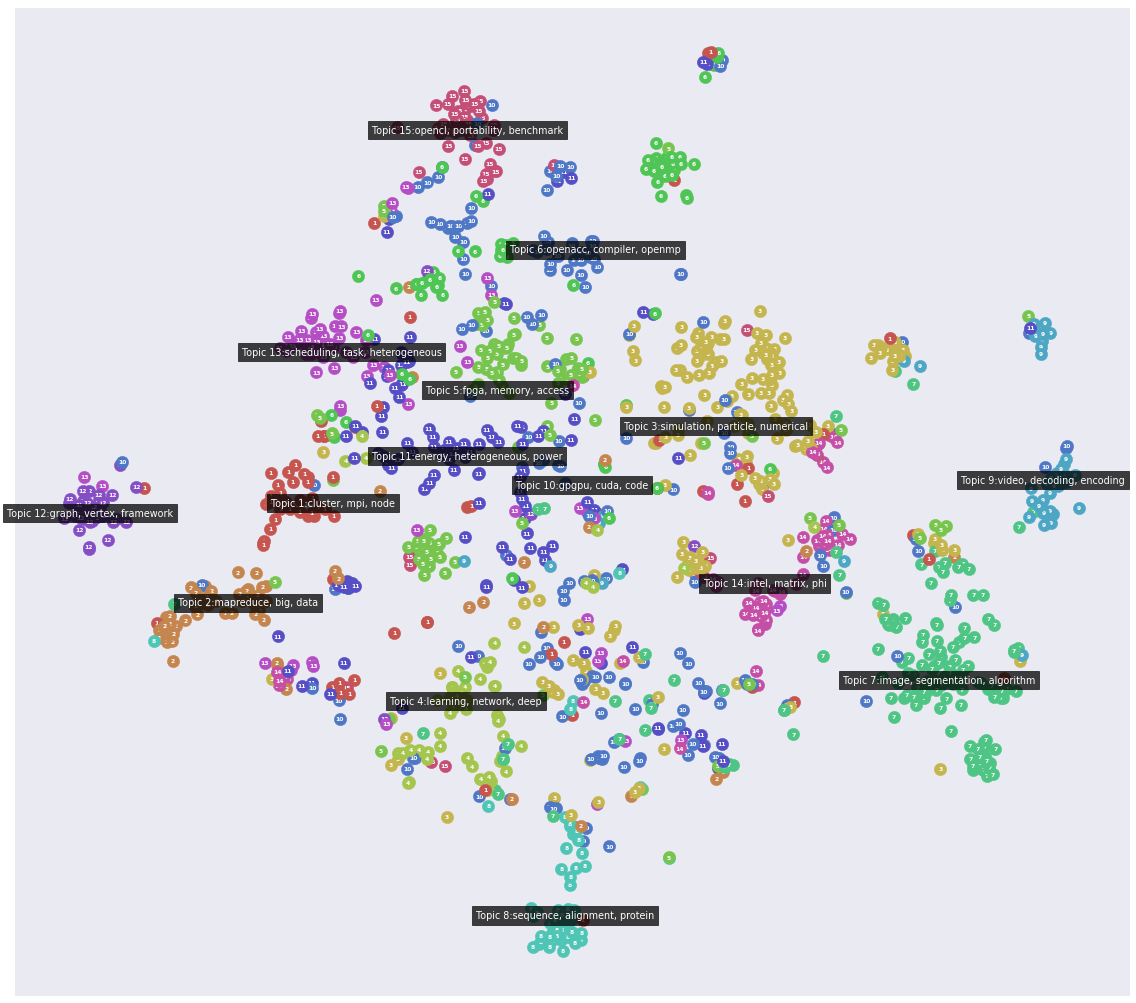

In [22]:
plt.figure(figsize=(20, 20))
litstudy.plot_embedding(corpus, topic_model);

## Advanced topic modeling

We can combine the results of topic modeling with the plotting of statistics. Here we show we a simple example.

First, we find the topic id for the topic that most strongly belongs to "deep_learning". Next, we annotate the document set with a "dl_topic" tag for document that strongly belong to this topic (i.e., weight above a certain threshold).

After this, we define two groups: documents that have the tag "dl_topic" and documents that do not have this tag.  We can, for example, print the publications over the years to see if interest in deep learning has increased or decreased over the years.

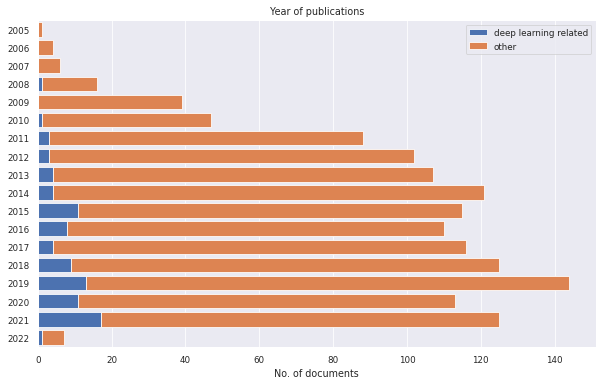

In [23]:
topic_id = topic_model.best_topic_for_token('deep_learning')

threshold = 0.2
dl_topic = topic_model.doc2topic[:, topic_id] > threshold

docs = docs.add_property('dl_topic', dl_topic)


groups = {
    'deep learning related': 'dl_topic',
    'other': '1 - dl_topic', 
}

litstudy.plot_year_histogram(docs, groups=groups, stacked=True);

The histogram shows that interest in deep learning is clearly rising over the years. We can even calculate the exact amount by calculating the percentage of documents on deep learning each year. The example below shows that this percentage has increased from just 3.4% in 2011 to 13.6% in 2021.

In [24]:
table = litstudy.compute_year_histogram(docs, groups=groups)
table = (table.T / table.sum(axis=1)).T * 100
table

,deep learning related,other
2005,0.000000,100.000000
2006,0.000000,100.000000
2007,0.000000,100.000000
2008,6.250000,93.750000
2009,0.000000,100.000000
2010,2.127660,97.872340
2011,3.409091,96.590909
2012,2.941176,97.058824
2013,3.738318,96.261682
2014,3.305785,96.694215


Alternatively, we can plot the two groups for the publications source. We can see that some journals/conferences have more focus on deep learning (for example, "Neural Computing and Applications"), while others have no or few publications on this topic (for example, "Journal of Real Time Image Processing").

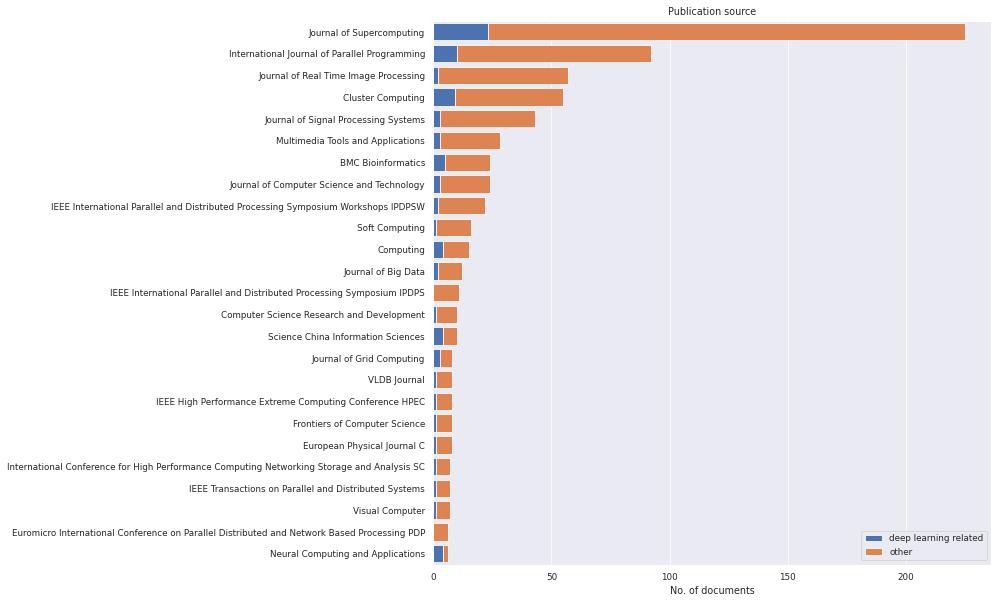

In [25]:
plt.figure(figsize=(10, 10))

dl_topic = topic_model.doc2topic[:, topic_id] > .1
docs = docs.add_property('dl_topic', dl_topic)

litstudy.plot_source_histogram(docs, groups=groups, limit=25, stacked=True);